<a href="https://colab.research.google.com/github/rajy4683/S5EVA4/blob/master/S5_EVA4_Attempt1_9948_9122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Final Accuracy: 99.48**
###  Number of parameters - 9122

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install wandb

     |████████████████████████████████| 112kB 25.4MB/s 
     |████████████████████████████████| 1.4MB 44.8MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 460kB 60.2MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 71kB 12.8MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
  Created wheel for shortuuid: filename=shortuuid-0.5.0-cp36-none-any.whl size=5497 sha256=4f1ae44583116052210e3f5e43ee2fb9c651d8176fa4063ea55508b07bb87667
  Stored in directory: /root/.cache/pip/wheels/3f/eb/fd/69e5177f67b505e44acbd1aedfbe44b91768ee0c4cd5636576
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=aad0b5b12a18fc3583f6932fd8286d9c9eb53b4b2fb27d89a951f3c1178c1ba9
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filena

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.data import DataLoader
from ignite.handlers import Checkpoint, DiskSaver


import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

from argparse import ArgumentParser
from tqdm import tqdm
import os

In [0]:
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [7]:
import wandb
#wandb.init()
#!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [46]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
hyperparameter_defaults = dict(
    dropout = 0.1,
    channels_one = 16,
    channels_two = 32,
    batch_size = 64,
    test_batch_size=64,
    lr = 0.015,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 20,
    bias = False,
    log_interval = 10
    )

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_val = config.dropout
        self.bias = False
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 8, 3, padding=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Conv2d(8, 8, 3, padding=1, bias=self.bias),
            # nn.ReLU(),
            # nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),            
            nn.Dropout(self.dropout_val)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),
            # nn.Conv2d(16, 16, 3, padding=1, bias=self.bias),
            # nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3,bias=self.bias),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1, bias=self.bias)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x


In [48]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, train_loss, train_accuracy, len(train_loader.dataset),
        100. * train_accuracy / len(train_loader.dataset)))
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)

    return train_accuracy, train_loss

def test(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))

    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)

    print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(test_accuracy)
    test_losses.append(test_loss)

    return test_accuracy, test_loss

In [52]:
#model = Net(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")



def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum)
    
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss})
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
    torch.save(model.state_dict(), "model.h5")
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

loss=0.07725239545106888 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.32it/s]


Epoch: 1 Train set: Average loss: 0.0035, Accuracy: 55936/60000 (93.227%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 Test set: Average loss: 0.0507, Accuracy: 9839/10000 (98.390%)



loss=0.01458863914012909 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.53it/s]



Epoch: 2 Train set: Average loss: 0.0014, Accuracy: 58341/60000 (97.235%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 Test set: Average loss: 0.0397, Accuracy: 9865/10000 (98.650%)



loss=0.024874597787857056 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.39it/s]



Epoch: 3 Train set: Average loss: 0.0012, Accuracy: 58627/60000 (97.712%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 Test set: Average loss: 0.0349, Accuracy: 9893/10000 (98.930%)



loss=0.009306788444519043 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.71it/s]


Epoch: 4 Train set: Average loss: 0.0010, Accuracy: 58757/60000 (97.928%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 Test set: Average loss: 0.0284, Accuracy: 9916/10000 (99.160%)



loss=0.018686741590499878 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 65.31it/s]


Epoch: 5 Train set: Average loss: 0.0009, Accuracy: 58910/60000 (98.183%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.100%)



loss=0.04889877140522003 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.69it/s]



Epoch: 6 Train set: Average loss: 0.0009, Accuracy: 59018/60000 (98.363%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.130%)



loss=0.07004483044147491 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 62.98it/s]



Epoch: 7 Train set: Average loss: 0.0008, Accuracy: 59059/60000 (98.432%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.230%)



loss=0.033603161573410034 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.21it/s]


Epoch: 8 Train set: Average loss: 0.0008, Accuracy: 59062/60000 (98.437%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.220%)



loss=0.15869329869747162 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 65.03it/s]


Epoch: 9 Train set: Average loss: 0.0007, Accuracy: 59144/60000 (98.573%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.330%)



loss=0.2189541906118393 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.32it/s]


Epoch: 10 Train set: Average loss: 0.0007, Accuracy: 59207/60000 (98.678%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.340%)



loss=0.019747570157051086 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 62.32it/s]



Epoch: 11 Train set: Average loss: 0.0007, Accuracy: 59205/60000 (98.675%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.310%)



loss=0.006195098161697388 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.56it/s]


Epoch: 12 Train set: Average loss: 0.0006, Accuracy: 59257/60000 (98.762%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 Test set: Average loss: 0.0221, Accuracy: 9924/10000 (99.240%)



loss=0.00042128562927246094 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.61it/s]


Epoch: 13 Train set: Average loss: 0.0006, Accuracy: 59295/60000 (98.825%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.410%)



loss=0.00554521381855011 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.64it/s]



Epoch: 14 Train set: Average loss: 0.0006, Accuracy: 59287/60000 (98.812%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 Test set: Average loss: 0.0184, Accuracy: 9931/10000 (99.310%)



loss=0.029601752758026123 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.75it/s]



Epoch: 15 Train set: Average loss: 0.0006, Accuracy: 59297/60000 (98.828%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.420%)



loss=0.04902336001396179 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.66it/s]


Epoch: 16 Train set: Average loss: 0.0006, Accuracy: 59305/60000 (98.842%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.410%)



loss=0.006149023771286011 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.81it/s]



Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 59331/60000 (98.885%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.350%)



loss=0.07999064028263092 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 63.57it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 59334/60000 (98.890%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.470%)



loss=0.000713348388671875 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 64.55it/s]



Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 59326/60000 (98.877%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.380%)



loss=0.0031184256076812744 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 65.34it/s]



Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 59346/60000 (98.910%)


Epoch: 20 Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.350%)



Text(0.5, 1.0, 'Test Accuracy')

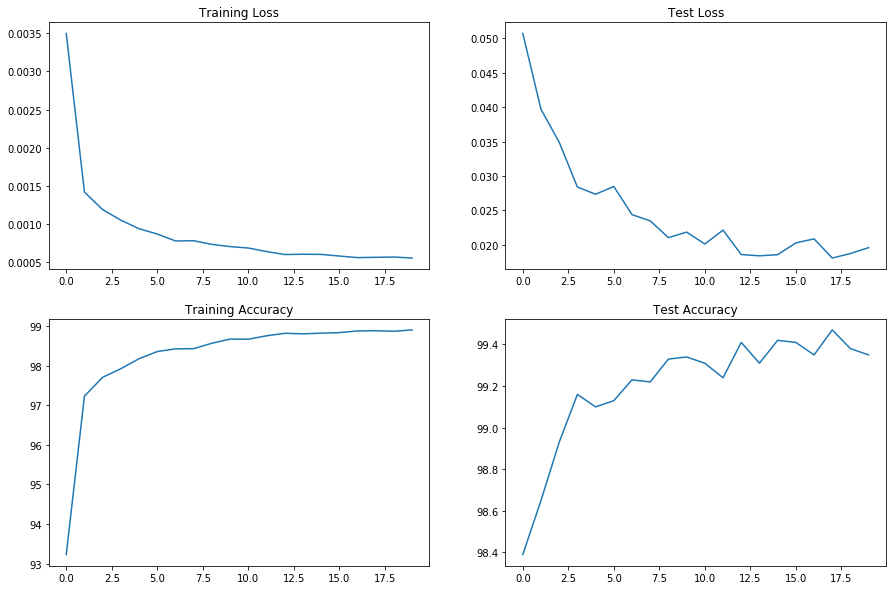

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Results of various runs are logged on the below link
##### https://app.wandb.ai/rajy4683/news4eva4?workspace=user-rajy4683



In [0]:
from IPython.display import IFrame

IFrame(src='https://app.wandb.ai/rajy4683/news4eva4/runs/r06vb1q0?workspace=user-rajy4683',width=700, height=600)

In [0]:
def plot_metrics(metrics_dataframe_local):
    dataset_metrics = metrics_dataframe_local.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')
    final_run_metrics = pd.concat([metrics_dataframe.loc[:,['Train Accuracy', 'Train Loss']].dropna().reset_index().drop(columns='index'), 
                                   metrics_dataframe.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')],axis=1)
    final_run_metrics.loc[:,['Train Accuracy', 'Test Accuracy']].plot()
    final_run_metrics.loc[:,['Train Loss', 'Test Loss']].plot()


RESULTS of the Final Run

In [0]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("rajy4683/news4eva4/1i1ns4m1")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

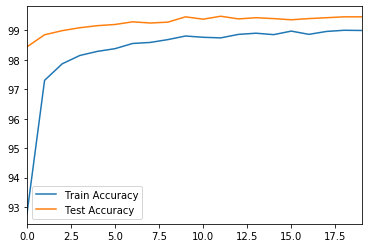

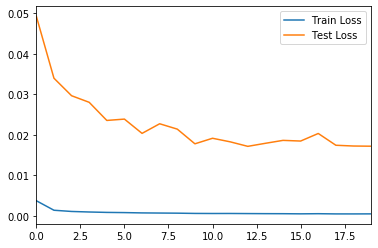

In [0]:
plot_metrics(metrics_dataframe)

    #### First attempt ####
    1. No doubling of layers
    2. Use 16 input channels for all layers
    3. Include BN.
    4. Max Accuracy = 99.48% within 20 Epochs
    5. Total params: 13,402
    #### 2nd attempt ####
    1. Swapped the last layers with GAP and 1x1 conv
    2. Max Accuracy = 99.46 within 20 Epochs
    3. Total params: 12122
    #### 3rd attempt ####
    1. Used 8 channels in first layer and 16 in the rest
    2. Max Accuracy = 99.43 within 20 Epochs
    3. Total params: 10,874
    #### 4th attempt ####
    1. Used 8 channels in first layer and 16 in the rest
    2. Max Accuracy = 99.41 within 20 Epochs
    3. Total params: 10,874
    4. Moved BN after RelU
    5. Training accurac
    #### 5th attempt ####
    1. Used 8 channels in first 2 layers
    2. Introduced Dropout after major Conv layers, as there was large delta between Training Accuracy and Test Accuracy
    3. Changed overall model to use nn.Sequential functions
    2. Max Accuracy = 99.48 within 20 Epochs
    3. Total params: 9122